# Assignment 2: Markov Decision Processes


## Homework Instructions
All your answers should be written in this notebook.  You shouldn't need to write or modify any other files.
Look for four instances of "YOUR CODE HERE"--those are the only parts of the code you need to write. To grade your homework, we will check whether the printouts immediately following your code match up with the results we got. The portions used for grading are highlighted in yellow. (However, note that the yellow highlighting does not show up when github renders this file.)

To submit your homework, send an email to <berkeleydeeprlcourse@gmail.com> with the subject line "Deep RL Assignment 2" and two attachments:
1. This `ipynb` file
2. A pdf version of this file (To make the pdf, do `File - Print Preview`)

The homework is due Febrary 22nd, 11:59 pm.

--------------------------

## Introduction

This assignment will review the two classic methods for solving Markov Decision Processes (MDPs) with finite state and action spaces.
We will implement value iteration (VI) and policy iteration (PI) for a finite MDP, both of which find the optimal policy in a finite number of iterations.

The experiments here will use the Frozen Lake environment, a simple gridworld MDP that is taken from `gym` and slightly modified for this assignment. In this MDP, the agent must navigate from the start state to the goal state on a 4x4 grid, with stochastic transitions.

In [32]:
from frozen_lake import FrozenLakeEnv
env = FrozenLakeEnv()
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


Let's look at what a random episode looks like.

In [33]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
np.set_printoptions(precision=3)
def begin_grading(): print("\x1b[43m")
def end_grading(): print("\x1b[0m")

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)
# Generate the episode
env.reset()
for t in range(100):
    env.render()
    a = env.action_space.sample()
    ob, rew, done, _ = env.step(a)
    if done:
        break
assert done
env.render();


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


In the episode above, the agent falls into a hole after two timesteps. Also note the stochasticity--on the first step, the DOWN action is selected, but the agent moves to the right.

We extract the relevant information from the gym Env into the MDP class below.
The `env` object won't be used any further, we'll just use the `mdp` object.

In [34]:
class MDP(object):
    def __init__(self, P, nS, nA, desc=None):
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
mdp = MDP( {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc)


print("mdp.P is a two-level dict where the first key is the state and the second key is the action.")
print("The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in")
print(np.arange(16).reshape(4,4))
print("mdp.P[state][action] is a list of tuples (probability, nextstate, reward).\n")
print("For example, state 0 is the initial state, and the transition information for s=0, a=0 is \nP[0][0] =", mdp.P[0][0], "\n")
print("As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.")
print("P[5][0] =", mdp.P[5][0], '\n')

mdp.P is a two-level dict where the first key is the state and the second key is the action.
The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
mdp.P[state][action] is a list of tuples (probability, nextstate, reward).

For example, state 0 is the initial state, and the transition information for s=0, a=0 is 
P[0][0] = [(0.1, 0, 0.0), (0.8, 0, 0.0), (0.1, 4, 0.0)] 

As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.
P[5][0] = [(1.0, 5, 0)] 



## Part 1: Value Iteration

### Problem 1: implement value iteration
In this problem, you'll implement value iteration, which has the following pseudocode:

---
Initialize $V^{(0)}(s)=0$, for all $s$

For $i=0, 1, 2, \dots$
- $V^{(i+1)}(s) = \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$, for all $s$

---

We additionally define the sequence of greedy policies $\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}$, where
$$\pi^{(i)}(s) = \arg \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$$

Your code will return two lists: $[V^{(0)}, V^{(1)}, \dots, V^{(n)}]$ and $[\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}]$

To ensure that you get the same policies as the reference solution, choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by np.argmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.

<div class="alert alert-warning">
Warning: make a copy of your value function each iteration and use that copy for the update--don't update your value function in place. 
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than me.
</div>

[[  7.943e-02   8.164e-02   4.772e-02   6.928e-02]
 [  5.736e-02   6.865e-03   2.721e-02   3.834e-02]
 [  3.710e-02   2.923e-02   4.879e-05   6.089e-03]
 [  0.000e+00   3.241e-04   1.620e-05   1.800e-05]
 [  8.634e-02   1.273e-01   2.873e-02   5.484e-02]
 [  0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [  0.000e+00   1.019e-01   8.185e-04   4.855e-03]
 [  0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [  1.616e-01   8.432e-02   1.651e-01   1.232e-01]
 [  1.324e-01   3.132e-01   2.324e-01   5.940e-02]
 [  2.242e-01   3.091e-01   7.831e-02   2.953e-02]
 [  0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [  0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [  1.161e-01   3.619e-01   5.589e-01   2.042e-01]
 [  3.455e-01   5.415e-01   8.987e-01   2.044e-01]
 [  0.000e+00   0.000e+00   0.000e+00   0.000e+00]]


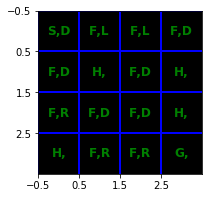

In [35]:
import random
import datetime

def sarsa_lambda(env, gamma, delta, rate, epsilon, nIt, render):
    random.seed(datetime.datetime.now().timestamp())
    
    q = np.array([0] * env.nS * env.nA, dtype = float).reshape(env.nS, env.nA)
    for i in range(nIt):
        trace = np.zeros_like(q)
        
        obs_prev = None
        act_prev = None
        
        obs = None
        done = False
        totalr = 0.
        # need to manipulate the structure a little bit as Sarsa(delta) needs an extra action sampling
        while not done:
            if render:
                env.render()
                
            if obs is None: 
                obs = env.reset()
            else:
                assert act is not None
                obs, r, done, _ = env.step(act)
                totalr += r
            
            p = np.random.uniform(0., 1.)
            if p > epsilon:
                act = np.argmax(q[obs])
            else:
                act = np.random.randint(4)
            # Sarsa(delta)
            # R and S are ready. Waiting for A. 
            if obs_prev is not None:
                trace *= delta * gamma
                trace[obs_prev][act_prev] += 1
                q += rate * trace * (r + gamma * q[obs][act] - q[obs_prev][act_prev])
            obs_prev = obs
            act_prev = act
            
        if render:
            env.render()
    
    return q

gamma = 0.9  # decay of reward
delta = 0.5  # decay of eligibility trace
rate = 0.1  # the learning rate, or alpha in the book
nIt = 1000
epsilon = 0.5  # epsilon greedy
q = sarsa_lambda(env, gamma, delta, rate, epsilon, nIt, False)
print(q)

import matplotlib.pyplot as plt
%matplotlib inline

def policy_matrix(q):
    indices = np.argmax(q, axis = 1)
    indices[np.max(q, axis = 1) == 0] = 4
    to_direction = np.vectorize(lambda x: ['L', 'D', 'R', 'U', ''][x])
    return to_direction(indices.reshape(4, 4))

plt.figure(figsize=(3,3))
# imshow makes top left the origin
plt.imshow(np.array([0] * 16).reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
ax = plt.gca()
ax.set_xticks(np.arange(4)-.5)
ax.set_yticks(np.arange(4)-.5)
directions = policy_matrix(q)
for y in range(4):
    for x in range(4):
        plt.text(x, y, str(env.desc[y,x].item().decode()) + ',' + directions[y, x],
                    color='g', size=12,  verticalalignment='center',
                 horizontalalignment='center', fontweight='bold')
plt.grid(color='b', lw=2, ls='-')
    